This file runs analyses on the ground truth gaze location data in the CodeCharts1K dataset, including:
* most highly gazed objects/scene parts
* images and objects for which gaze distribution changes most between viewing durations
* proportion of gaze locations that fall on different semantic objects at different viewing durations
* patterns of attention on faces across viewing durations (at which viewing durations face saliency increases/decreases)

This file was used to compute the values reported and figures included in Fosco, Newman, et al. (CVPR 2020), including: Section 4 in the main paper, and Section 2 in the supplemental material.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import os
from PIL import Image
import importlib
from collections import Counter
import math
import spotlight as sp
import matplotlib.cm as cm
import glob
cm_hot = cm.get_cmap('hot')
import operator
from tqdm import tqdm
import pickle
import pandas as pd
import seaborn as sn
import matplotlib.patches as patches
import scipy
from scipy import stats
from scipy.ndimage.filters import gaussian_filter

In [2]:
# our dataset, containing images and gaze locations
datapath = 'CodeCharts1k/'
imdir = os.path.join(datapath,'raw_img')
times = [500,3000,5000]

In [3]:
# source of annotation data, downloaded from: https://github.com/nightrome/cocostuff
coco_dir = '../../attention-code-charts-eyetracking-datasets/COCO/stuffthingmaps_trainval2017/'
annotation_dir = os.path.join(coco_dir,'train2017/')

# read out the mapping from object IDs to object labels
with open(os.path.join(coco_dir,'labels.txt')) as f:
    lines = f.read().splitlines()
D_labels = {int(elem.split(':')[0]):elem.split(':')[1].strip() for elem in lines}
D_labels[255] = 'unlabeled'
obj_IDs = list(D_labels.keys())

In [4]:
# helper function to track which gaze points fall in which image segments (objects)
def get_fixations_in_segmented_objects(curfilename,time,todebug=True,toplot=False):
    
    Dict_fix_per_obj = {}
    
    # coordinates
    with open(os.path.join(datapath,'fix_coords/%d'%(time),curfilename+'.json')) as f:
        coords = json.load(f)
    
    # original image
    origimname = os.path.join(imdir,curfilename+'.jpg')
    origim = Image.open(origimname).convert('RGB')
    
    if todebug: print(curfilename)
    
    # annotation file
    seg_name = curfilename.split('_')[-1]+'.png'
    if not os.path.exists(os.path.join(annotation_dir,seg_name)):
        return
    im = Image.open(os.path.join(annotation_dir,seg_name)) 
    im = im.resize(origim.size, Image.NEAREST)
    indexed = np.array(im) # Convert to NumPy array to easier access
    indexed += 1 # offset for labels to be accurate
    
    imobjects,_ = np.unique(indexed, return_counts=True)
    
    if toplot:
        fig,ax = plt.subplots(1,1,figsize=(10,10))

    counts = []
    totfixations = []

    fixated_objects = [indexed[y,x] for x,y in coords]
    counts = Counter(fixated_objects)
    totfixations = len(coords)

    if toplot:
        ax.imshow(im); ax.set_axis_off(); 
        for x,y in coords:
            ax.plot(x,y,color='r',marker='X',markersize=5)
        plt.show()
    
    # accumulate proportion of gaze points in each object in the current image
    for obj in imobjects:
        if todebug: print('%s (%d):'%(D_labels[obj],obj))
        if counts[obj]==0:
            Dict_fix_per_obj[obj] = 0
        else:
            perc_fix = counts[obj]*100/float(totfixations)
            Dict_fix_per_obj[obj] = perc_fix
        if todebug: print('%d%%'%(Dict_fix_per_obj[obj]))

    return Dict_fix_per_obj,imobjects

In [ ]:
# helper function to compute heatmap from fixation coordinates
def get_heatmap_for_coords(filename,coords,base_path,sigma=50,toplot=False):
    
    imfilename = os.path.join(base_path, filename)
    im = Image.open(imfilename).convert('RGB')
    [width,height] = im.size
    
    temp = np.zeros([height,width])
    for ii in range(len(coords)):
        if type(coords[ii])==list:
            if int(coords[ii][1])<height and int(coords[ii][0])<width:
                temp[int(coords[ii][1]),int(coords[ii][0])] += 1
        
    res = scipy.ndimage.filters.gaussian_filter(temp,[sigma,sigma]);
    
    if toplot:
        plt.imshow(res);
    
    return res,im

## Demo plotting gaze locations on a single COCO image and object segmentations ##

In [5]:
curfilename = 'COCO_train2014_000000271058'

In [6]:
# load gaze points collected on curfilename at the viewing duration of 500ms
with open(os.path.join(datapath,'fix_coords/500',curfilename+'.json')) as f:
    coords = json.load(f)

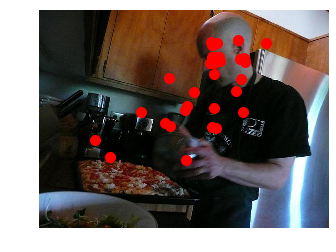

In [7]:
# plot gaze points on original image
origimname = os.path.join(imdir,curfilename+'.jpg')
origim = Image.open(origimname)
plt.imshow(origim); plt.axis('off')
for x,y in coords:
    plt.plot(x,y,color='r',marker='o',markersize=10)

In [8]:
# load segmentation image and convert to appropriate format
seg_name = curfilename.split('_')[-1]+'.png'
print('Image file %s correspond to segmentation file %s'%(curfilename,seg_name))
im = Image.open(os.path.join(annotation_dir,seg_name)) 
im = im.resize(origim.size, Image.NEAREST)
indexed = np.array(im) # Convert to NumPy array to easier access
indexed += 1 # had to offset for labels to be accurate
#plt.imshow(indexed); plt.axis('off')

Image file COCO_train2014_000000271058 correspond to segmentation file 000000271058.png


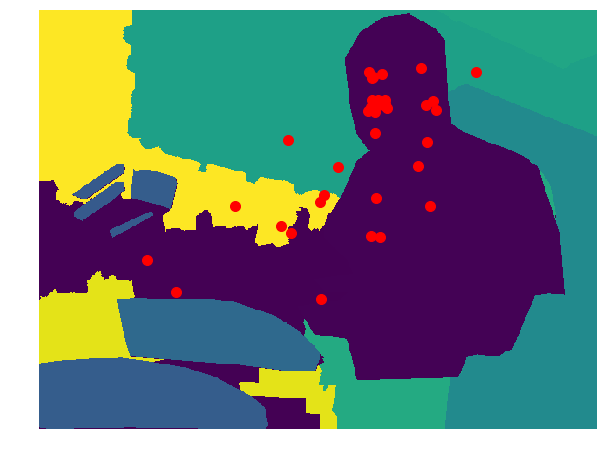

In [9]:
# plot gaze points on segmentation image
fig,ax = plt.subplots(1,figsize=(10,10))
ax.imshow(indexed); plt.axis('off'); 
for x,y in coords:
    plt.plot(x,y,color='r',marker='o',markersize=10)

In [10]:
# print out the number of gaze points falling in different image regions/objects:
res = get_fixations_in_segmented_objects(curfilename,time=500,todebug=True,toplot=False)

COCO_train2014_000000271058
unlabeled (0):
9%
person (1):
74%
knife (49):
0%
bowl (51):
0%
pizza (59):
0%
refrigerator (82):
0%
cabinet (98):
6%
ceiling-other (102):
0%
clothes (105):
0%
table (165):
0%
wall-concrete (172):
9%


## Accumulate gaze points in objects across all COCO images in our CodeCharts dataset ##

In [11]:
# find which objects increase/decrease in number of fixations over time
# get fixation counts across all images

files = glob.glob(os.path.join(datapath,'fix_coords/500/*.json'))

Counter_inc_dec = {}
for i in tqdm(range(len(files))): # iterate over all filenames in our dataset
    basename = os.path.basename(files[i])
    
    if 'COCO' not in basename: continue # segmentations only available for COCO images (500/1000 images of our dataset)
    
    imname,ext = os.path.splitext(basename)
    
    # ------ separately accumulate gaze points across the three different viewing durations ------
    res = get_fixations_in_segmented_objects(imname,time=5000,todebug=False,toplot=False)
    if res is None:
        continue
    Dict_fix_per_obj1,imobjects1 = res
    
    res = get_fixations_in_segmented_objects(imname,time=3000,todebug=False,toplot=False)
    if res is None:
        continue
    Dict_fix_per_obj2,imobjects2 = res
    
    res = get_fixations_in_segmented_objects(imname,time=500,todebug=False,toplot=False)
    if res is None:
        continue
    Dict_fix_per_obj3,imobjects3 = res
    
    # ------ iterate over all image regions/objects and tally which objects increased/decreased in 
    # saliency (gaze points) across different viewing durations
    for objid in imobjects1:
        
        if objid not in Counter_inc_dec: Counter_inc_dec[objid] = []
        diff = Dict_fix_per_obj1[objid]-Dict_fix_per_obj2[objid]
        if diff < 0: 
            diff = -1
        elif diff > 0:
            diff = 1
        else:
            diff = 0
        
        diff2 = Dict_fix_per_obj2[objid]-Dict_fix_per_obj3[objid]
        if diff2 < 0: 
            diff2 = -1
        elif diff2 > 0:
            diff2 = 1
        else:
            diff2 = 0
            
        Counter_inc_dec[objid].append([diff,diff2])

100%|██████████| 1000/1000 [02:10<00:00,  8.08it/s]


In [12]:
# tally the number of images for which objects increased/decreased in saliency
Counter_inc_dec_sum = {}
Counter_inc_dec_counts = {}
Counter_inc_dec_sum_both = {}
for objid in Counter_inc_dec.keys():
    Counter_inc_dec_sum[objid] = [np.sum(elem[0] for elem in Counter_inc_dec[objid]),\
                                  np.sum(elem[1] for elem in Counter_inc_dec[objid])]#/float(len(Counter_inc_dec[objid]))
    Counter_inc_dec_sum_both[objid] = abs(Counter_inc_dec_sum[objid][0])+abs(Counter_inc_dec_sum[objid][1])
    Counter_inc_dec_counts[objid] = len(Counter_inc_dec[objid])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  import sys


In [13]:
# print out the set of objects that occured in at least thresh images, and print for how many images in the dataet 
# they increased/decreased in saliency between 500 and 3000 ms and between 3000 and 5000 ms
thresh = 20 # at least this many images should have this object
sorted_x = sorted(Counter_inc_dec_sum_both.items(), key=operator.itemgetter(1))

with open('sorted_objects.csv',mode='w') as f:
    for objid,score in sorted_x:
        if Counter_inc_dec_counts[objid] > thresh:
            print('%s = %d (across %d images)'%(D_labels[objid],score,Counter_inc_dec_counts[objid]))
            print(Counter_inc_dec_sum[objid])
            f.write('%s,%d,%d\n'%(D_labels[objid],Counter_inc_dec_sum[objid][0],Counter_inc_dec_sum[objid][1]))

oven = 1 (across 32 images)
[0, 1]
mouse = 1 (across 28 images)
[-1, 0]
pillow = 1 (across 21 images)
[-1, 0]
bus = 2 (across 43 images)
[1, 1]
roof = 2 (across 21 images)
[-2, 0]
cabinet = 2 (across 69 images)
[-2, 0]
cell phone = 2 (across 24 images)
[1, 1]
textile-other = 3 (across 82 images)
[1, -2]
plant-other = 3 (across 40 images)
[-1, 2]
house = 3 (across 24 images)
[3, 0]
flower = 3 (across 25 images)
[3, 0]
cloth = 3 (across 22 images)
[-1, -2]
wall-brick = 3 (across 23 images)
[3, 0]
dirt = 3 (across 21 images)
[2, 1]
backpack = 4 (across 48 images)
[1, 3]
bush = 4 (across 29 images)
[4, 0]
bicycle = 5 (across 23 images)
[5, 0]
vase = 5 (across 31 images)
[2, -3]
mirror-stuff = 6 (across 21 images)
[-1, 5]
knife = 6 (across 43 images)
[2, 4]
door-stuff = 6 (across 52 images)
[-5, 1]
shelf = 6 (across 43 images)
[3, 3]
fence = 6 (across 44 images)
[-4, 2]
sink = 7 (across 30 images)
[6, 1]
light = 7 (across 81 images)
[-5, 2]
wall-tile = 7 (across 29 images)
[5, -2]
playingfi

In [14]:
# keep track of number of gaze points per object across all images in large #images x #objects matrices, 
# one per image duration
imnames = files#[:5]

M_fix_per_time = {} # will house 3 matrices, one for each time point, with (# images) rows and (# obj_IDs) columns
                    # note: rows of matrices add up to 100% because element (i,j) is percent of fixations on object j
                    # in image i (sum across all objects j in image i should be 100)
        
M_score_per_time = {} # normalized value (saliency of objects per image normalized between 0 and 1)   

for time in times:
    M_fix_per_time[time] = np.zeros((len(imnames), len(obj_IDs)))
    M_score_per_time[time] = np.zeros((len(imnames), len(obj_IDs)))
    
M_obj_per_image = np.zeros((len(imnames), len(obj_IDs))) # presence of objects per images      

for i in range(len(imnames)):
    
    basename = os.path.basename(imnames[i])
    if 'COCO' not in basename: continue
    imname,ext = os.path.splitext(basename)
    
    for time in times: 
    
        res = get_fixations_in_segmented_objects(imname,time,todebug=False,toplot=False)
        if res:
            Dict_fix_per_obj,imobjects = res
        else:
            continue

        for io in range(len(obj_IDs)):
            if obj_IDs[io] in imobjects:
                
                M_obj_per_image[i,io] = 1
                M_fix_per_time[time][i,io] = Dict_fix_per_obj[obj_IDs[io]]

                # score matrix
                vals = list(Dict_fix_per_obj.values())
                maxval,minval = np.max(vals),np.min(vals)
                M_score_per_time[time][i,io] = (Dict_fix_per_obj[obj_IDs[io]]-minval)/(maxval-minval)


COCO_train2014_000000201724
Change in fixations from 68% to 73% to 39%


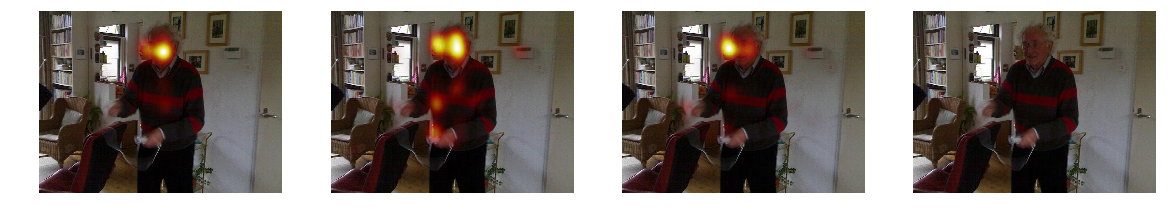

COCO_train2014_000000436108
Change in fixations from 67% to 70% to 42%


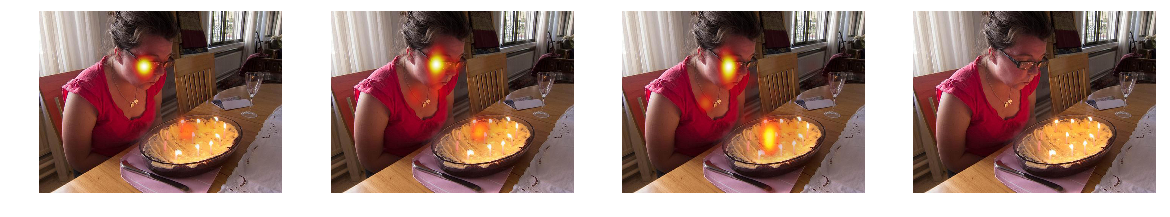

COCO_train2014_000000477005
Change in fixations from 35% to 56% to 31%


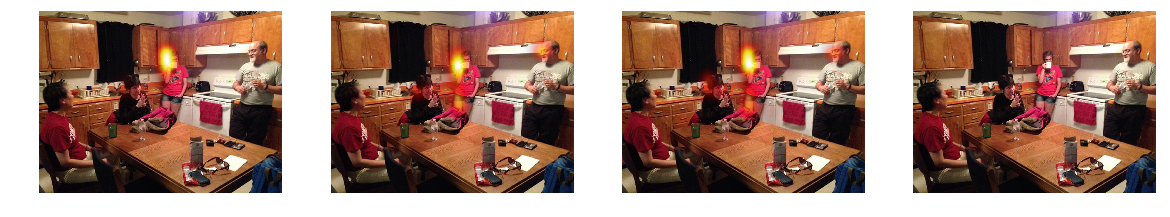

COCO_train2014_000000395445
Change in fixations from 73% to 40% to 64%


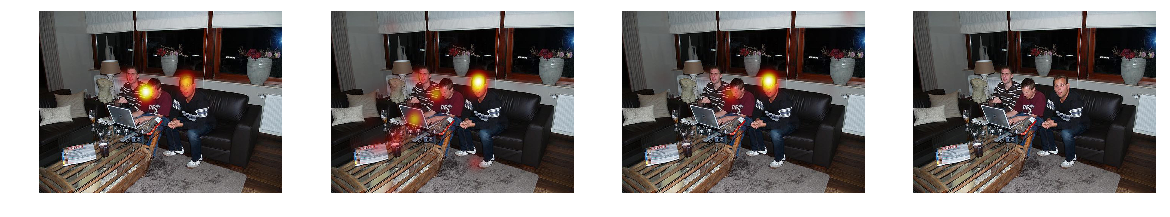

COCO_train2014_000000053632
Change in fixations from 43% to 58% to 35%


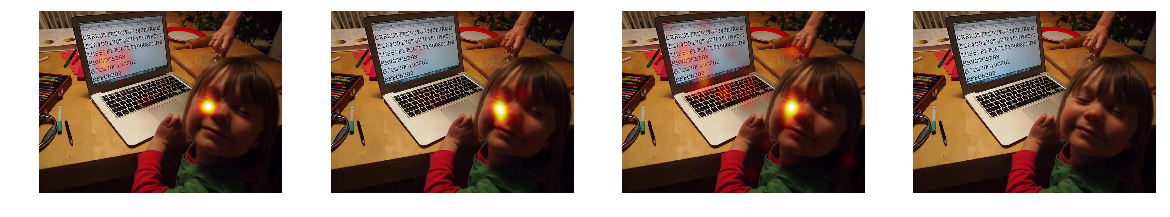

COCO_train2014_000000020770
Change in fixations from 61% to 32% to 9%


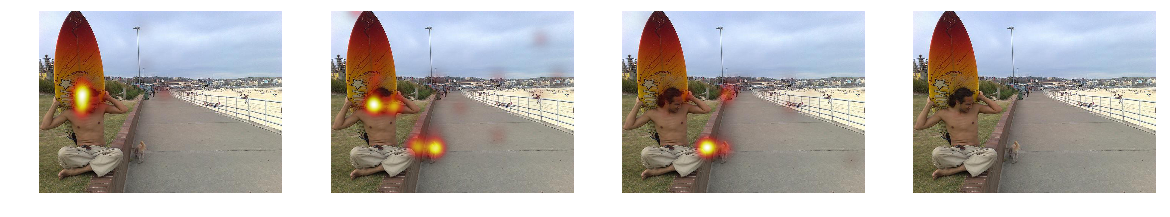

COCO_train2014_000000081065
Change in fixations from 81% to 46% to 69%


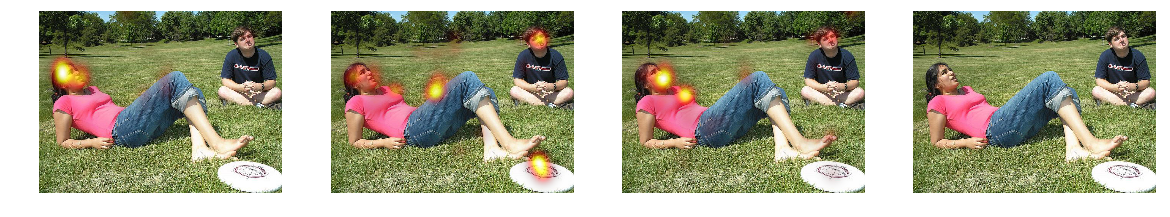

COCO_train2014_000000295358
Change in fixations from 34% to 34% to 11%


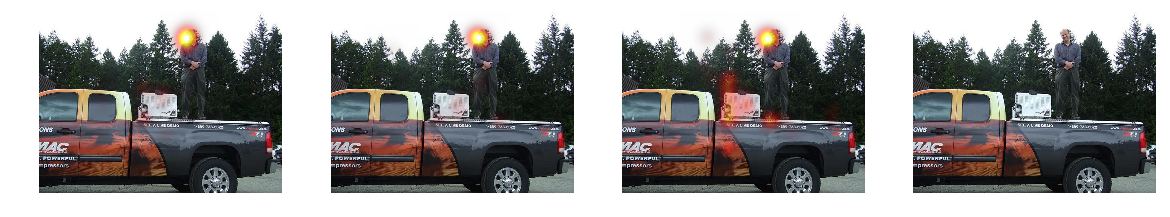

COCO_train2014_000000505552
Change in fixations from 39% to 60% to 38%


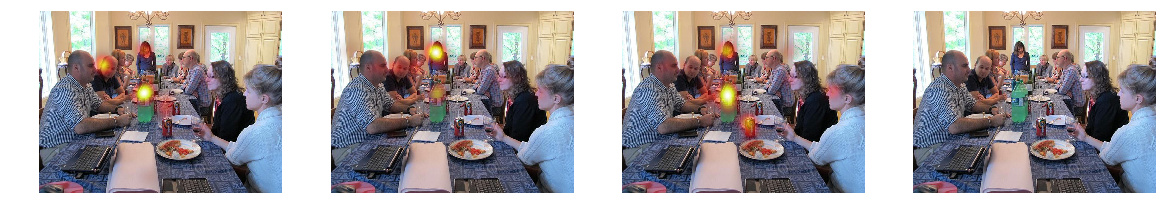

COCO_train2014_000000376831
Change in fixations from 42% to 9% to 29%


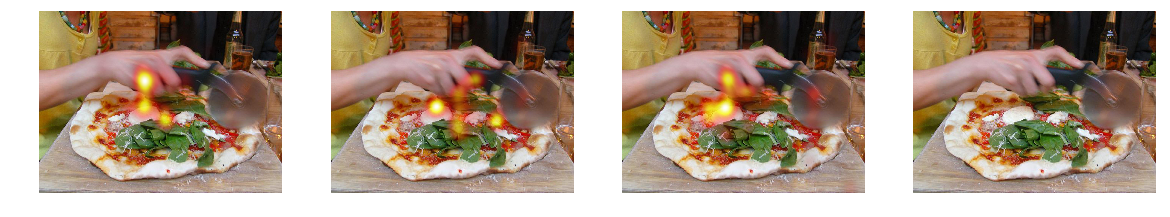

In [15]:
# plot top K images where % of gaze points on objname changes most between viewing durations
K = 10
objname = 'person'

curtime1 = 500
curtime2 = 3000
curtime3 = 5000

obj_key = [item[0] for item in D_labels.items() if item[1] == objname]
assert(len(obj_key)==1) # if not, probably 'other' category
obj_key = obj_key[0]
array_index = obj_IDs.index(obj_key)

fix1 = M_fix_per_time[curtime1][:,array_index]
fix2 = M_fix_per_time[curtime2][:,array_index]
fix3 = M_fix_per_time[curtime3][:,array_index]

diff = abs(fix2-fix3)
im_inds_fix_changed = np.argsort(diff)[::-1]
for i in range(K):

    basename = os.path.basename(imnames[im_inds_fix_changed[i]])
    if 'COCO' not in basename: continue
    imname,ext = os.path.splitext(basename)
    
    print(imname)
    print('Change in fixations from %d%% to %d%% to %d%%'%(fix1[im_inds_fix_changed[i]],\
                                                   fix2[im_inds_fix_changed[i]],\
                                                   fix3[im_inds_fix_changed[i]]))
    
    fig, ax = plt.subplots(1, 4, figsize=(20,20))
    for t in range(len(times)):
        
        with open(os.path.join(datapath,'fix_coords/%d'%(times[t]),imname+'.json')) as f:
            coords = json.load(f)
        
        res,im = get_heatmap_for_coords(imname+'.jpg',coords,imdir,sigma=50,toplot=False)
        res_final = sp.heatmap_overlay(im,res,colmap='hot')
        ax[t].imshow(res_final);
        
        ax[t].set_axis_off()
    
    ax[t+1].imshow(im); ax[t+1].set_axis_off()
    
    plt.show();
    
    

## Accumulate gaze points on faces using face detections ##

In [16]:
# precomputed face detections
with open("face_detections/salicon500.json", "r") as read_file:
    face_annotations = json.load(read_file)
# (image_name) -> [top, right, bottom, left]

with open("face_detections/out_of_context500.json", "r") as read_file:
    face_annotations2 = json.load(read_file)
    
face_annotations.update(face_annotations2)   

In [17]:
files = glob.glob(os.path.join(datapath,'fix_coords/500/*.json'))
imnames = [os.path.basename(file).split('.')[0]+'.jpg' for file in files]
faceims = [imname for imname in imnames if imname in face_annotations and len(face_annotations[imname])>0]
print('Found face in %d images'%(len(faceims)))

Found face in 303 images


In [18]:
# filter out false positives
false_positives = [26,51,66,72,79,107,109,118,146,149,176,179,190,229,230,242,252,274,302] # manually filtered
faceims = [faceims[i] for i in range(len(faceims)) if i not in false_positives]
print('Found face in %d images (after removing false positives)'%(len(faceims)))

Found face in 284 images (after removing false positives)


In [19]:
todebug = False
K = 10 # only generate plots for this many images
    
propfix = {}

for i in range(len(faceims)):
    
    imname = faceims[i]

    annots = face_annotations[imname]

    if todebug and i<K:
        fig, ax = plt.subplots(1, len(times), figsize=(20,10))   

    propfix[imname] = [None]*len(times)
    
    for t in range(len(times)):

        with open(os.path.join(datapath,'fix_coords/%d'%(times[t]),imname.split('.')[0]+'.json')) as f:
            coords = json.load(f)
        
        res,im = get_heatmap_for_coords(imname,coords,imdir,sigma=50,toplot=False)

        N = len(coords)

        if todebug and i<K:
            spotlight_res = sp.spotlight(im,res,toplot=False);
            ax[t].imshow(spotlight_res); 

            
        # accumulate gaze points landing in face detections in each image
        coords_in_faces = []
        for annot in annots:
            # left,top,right-left(width),bottom-top(height)
            if todebug and i<K:
                rect = patches.Rectangle((annot[3],annot[0]),annot[1]-annot[3],annot[2]-annot[0],linewidth=1,edgecolor='r',facecolor='none')
                ax[t].add_patch(rect)

            for ii in range(N):
                x,y = coords[ii]
                if annot[3]<=x<=annot[1] and annot[0]<=y<annot[2]:
                    coords_in_faces.append([x,y]) # accumulate coords over multiple face annotations
                    if todebug and i<K:
                        ax[t].plot(x,y,color='r',marker='o',markersize=5)

        if N==0:
            propfix[imname][t] = 0
        else:
            propfix[imname][t] = len(coords_in_faces)/float(N)
                    
                    
        if todebug and i<K:
            ax[t].set_axis_off(); ax[t].set_title('Time: %d ms (%d users)'%(times[t],N))

    if todebug:
        plt.show();

In [20]:
nfaces = {imname:len(face_annotations[imname]) for imname in faceims}

In [21]:
propfix_saved = propfix

In [22]:
norm_vals = []
face_vals = []
for key,val in propfix.items():
    if np.max(val)==0:
        norm_vals.append(val)
    else:
        norm_vals.append(val/np.max(val))
    face_vals.append(nfaces[key])

In [23]:
mapping = {0:'increasing',1:'decreasing',2:'inverse boomerang',3:'boomerang',4:'equal'}
hues = [None]*len(norm_vals)
for i in range(len(norm_vals)):
    if norm_vals[i][0] == norm_vals[i][1] == norm_vals[i][2]:
        hues[i] = 4 # equal
    elif norm_vals[i][0] <= norm_vals[i][1] <= norm_vals[i][2]:
        hues[i] = 0 # increasing
    elif norm_vals[i][0] >= norm_vals[i][1] >= norm_vals[i][2]:
        hues[i] = 1 # decreasing
    elif norm_vals[i][1] >= norm_vals[i][0] and norm_vals[i][1] >= norm_vals[i][2]:
        hues[i] = 2 # inverse boomerang
    elif norm_vals[i][1] <= norm_vals[i][0] and norm_vals[i][1] <= norm_vals[i][2]:
        hues[i] = 3 # boomerang
counts = Counter(hues)
totinsts = np.sum(list(counts.values()))
for k in mapping:
    print('%d%% instances of %s'%(counts[k]*100.0/totinsts,mapping[k]))

14% instances of increasing
24% instances of decreasing
18% instances of inverse boomerang
33% instances of boomerang
10% instances of equal



 1 faces
9% instances of increasing
30% instances of decreasing
16% instances of inverse boomerang
33% instances of boomerang
11% instances of equal

 2 faces
9% instances of increasing
23% instances of decreasing
21% instances of inverse boomerang
34% instances of boomerang
10% instances of equal

 3 faces
14% instances of increasing
28% instances of decreasing
17% instances of inverse boomerang
25% instances of boomerang
14% instances of equal

 4 faces
33% instances of increasing
11% instances of decreasing
22% instances of inverse boomerang
33% instances of boomerang
0% instances of equal

 5 faces
27% instances of increasing
0% instances of decreasing
36% instances of inverse boomerang
27% instances of boomerang
9% instances of equal

 6 faces
50% instances of increasing
12% instances of decreasing
0% instances of inverse boomerang
37% instances of boomerang
0% instances of equal

 7 faces
16% instances of increasing
16% instances of decreasing
0% instances of inverse boomerang
5

([<matplotlib.axis.XTick at 0x12c5c0050>,
 <a list of 5 Text xticklabel objects>)

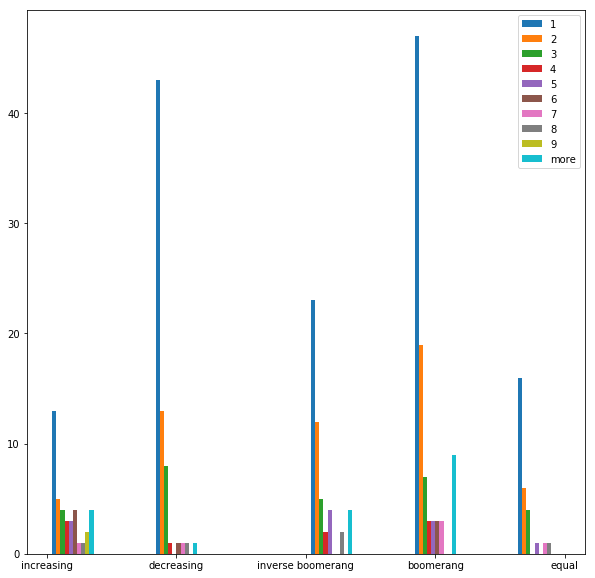

In [24]:
fig = plt.figure(figsize=(10,10))
xs = []
label = []
for nf in range(1,10):
    res = [hues[i] for i in range(len(hues)) if face_vals[i]==nf]
    xs.append(res)
    label.append(nf)
    
    counts = Counter(res)
    totinsts = np.sum(list(counts.values()))
    print('\n %d faces'%nf)
    for k in mapping:
        print('%d%% instances of %s'%(counts[k]*100.0/totinsts,mapping[k]))
    
xs.append([hues[i] for i in range(len(hues)) if face_vals[i]>=10])
label.append('more')
plt.hist(xs,label=label)
plt.legend()
plt.xticks(np.arange(5), ('increasing', 'decreasing', 'inverse boomerang', 'boomerang', 'equal'))

(275.0, 5225.0, -0.05, 1.05)

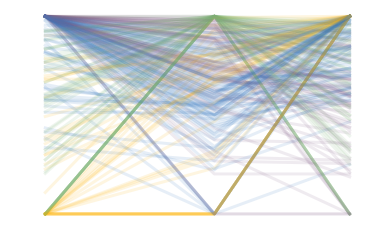

In [25]:
colors = ["amber","dusty purple", "faded green","windows blue"]
res = sn.xkcd_palette(colors)

for i in range(len(norm_vals)):
    vals = norm_vals[i]
    if hues[i]==0 or hues[i]==2:
        plt.plot(times, vals, alpha=0.12, color=res[hues[i]],linewidth=3)
    elif hues[i]==1:
        plt.plot(times, vals, alpha=0.12, color=res[hues[i]],linewidth=3)
    elif hues[i]==3:
        plt.plot(times, vals, alpha=0.12, color=res[hues[i]],linewidth=3)
plt.axis('off')

(275.0, 5225.0, -0.05, 1.05)

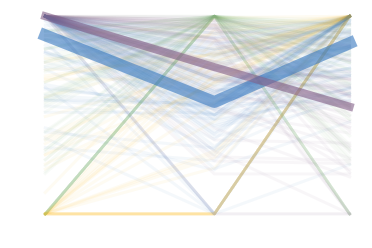

In [26]:
norm_vals_3 = [norm_vals[i] for i in range(len(norm_vals)) if hues[i]==3]
nv3 = np.mean(norm_vals_3,axis=0)

nv = [None]*4
for j in range(4):
    norm_vals_ = [norm_vals[i] for i in range(len(norm_vals)) if hues[i]==j]
    nv[j] = np.mean(norm_vals_,axis=0)

for i in range(len(norm_vals)):
    vals = norm_vals[i]
    if hues[i]==0 or hues[i]==2:
        plt.plot(times, vals, alpha=0.05, color=res[hues[i]],linewidth=3)
    elif hues[i]==1:
        plt.plot(times, vals, alpha=0.05, color=res[hues[i]],linewidth=3)
    elif hues[i]==3:
        plt.plot(times, vals, alpha=0.05, color=res[hues[i]],linewidth=3)

plt.plot(times, nv[3], alpha=0.6, color=res[3],linewidth=12)
plt.plot(times, nv[1], alpha=0.6, color=res[1],linewidth=8)   
plt.axis('off')

## Plot all images that have faces with attention maps overlaid ##

im 0/284


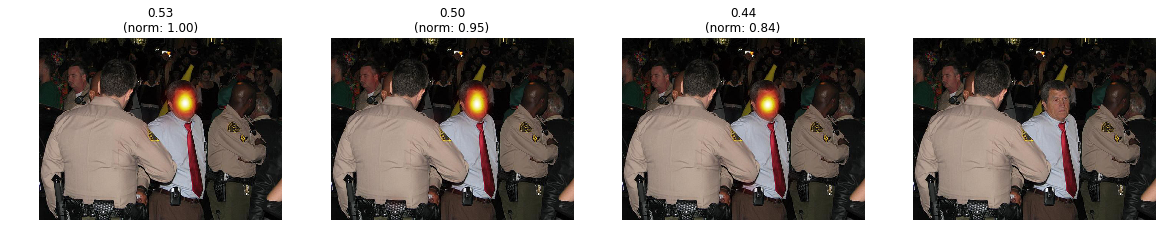

im 1/284


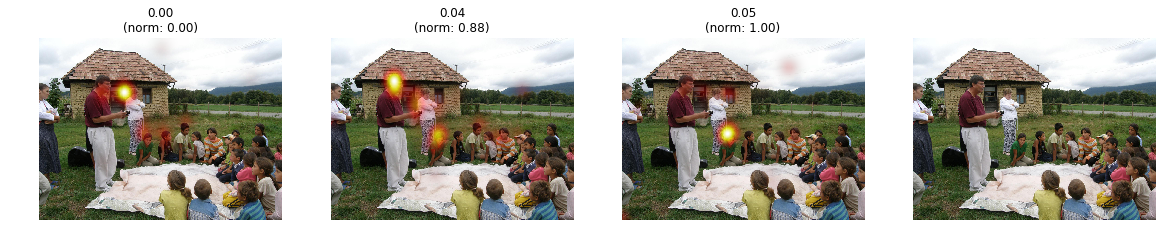

im 2/284


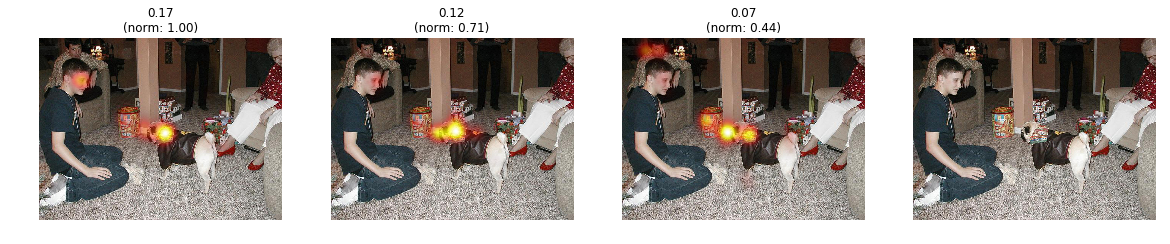

im 3/284


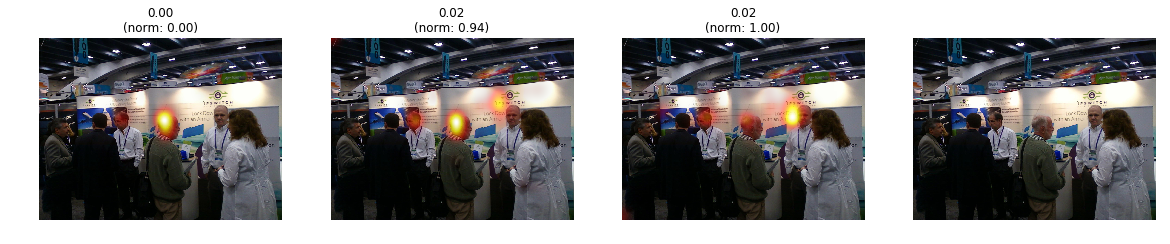

im 4/284


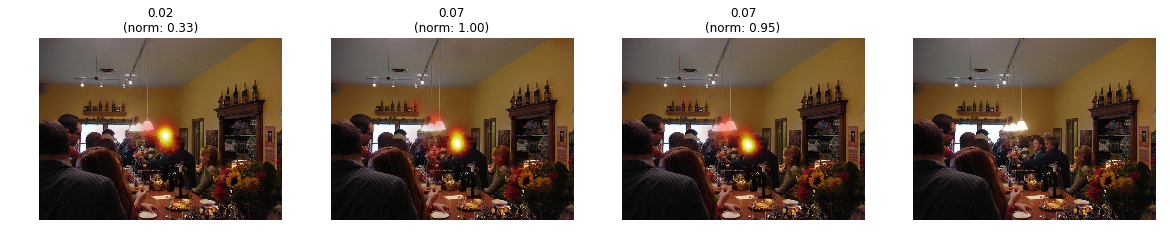

im 5/284


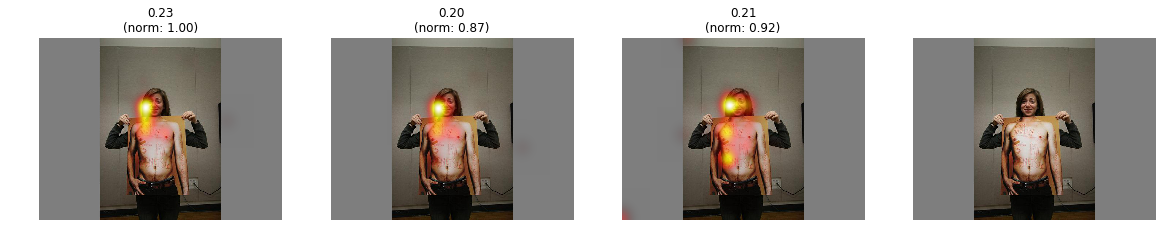

im 6/284


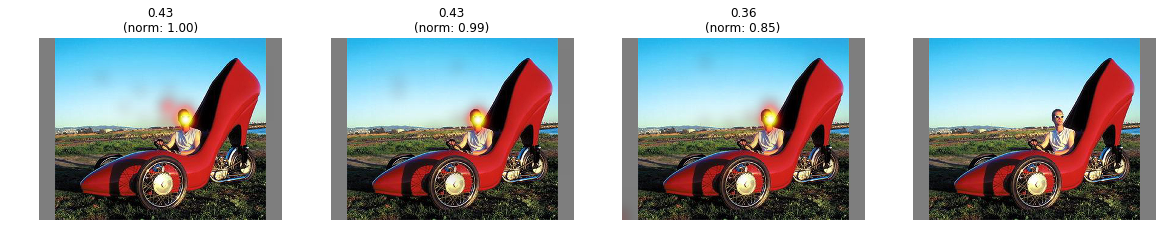

im 7/284


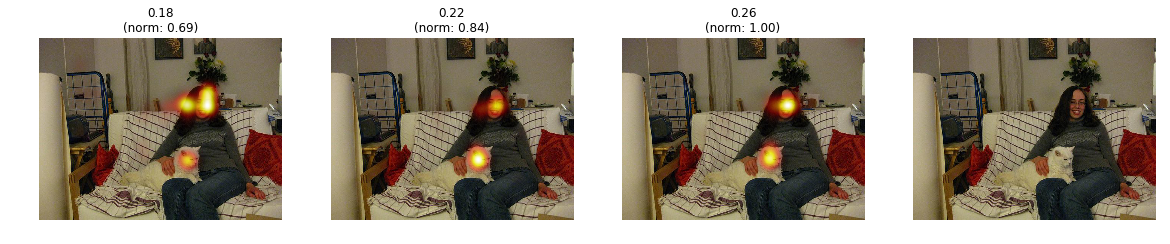

im 8/284


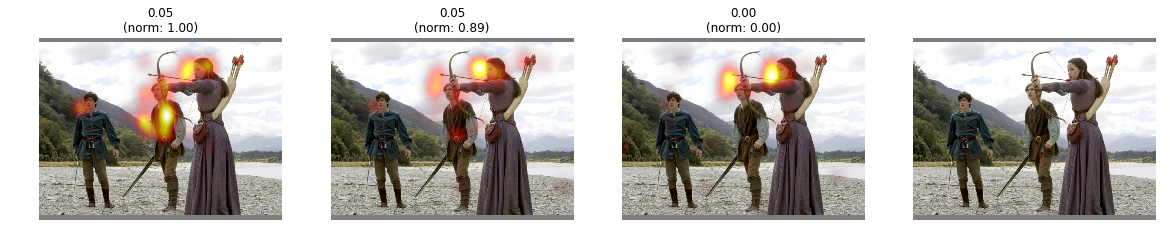

In [27]:
# plot K images containing detected faces, by overlaying the attention maps
K = 10
imnum = 0
for imname in faceims[1:K]:
        
    print('im %d/%d'%(imnum,len(faceims)))
    imnum += 1

    basename = os.path.basename(imname)
    imname,ext = os.path.splitext(basename)
    
    fig, ax = plt.subplots(1, 4, figsize=(20,20))
    for t in range(len(times)):
        
        with open(os.path.join(datapath,'fix_coords/%d'%(times[t]),imname+'.json')) as f:
            coords = json.load(f)
        
        res,im = get_heatmap_for_coords(imname+'.jpg',coords,imdir,sigma=50,toplot=False)
        res_final = sp.heatmap_overlay(im,res,colmap='hot')
        ax[t].imshow(res_final);
        face_score = propfix[imname+'.jpg'][t];
        ax[t].set_title('%2.2f\n(norm: %2.2f)'%(face_score,face_score/np.max(propfix[imname+'.jpg'])));
        ax[t].set_axis_off();
    
    ax[t+1].imshow(im); ax[t+1].set_axis_off(); 
    
    plt.show();
    
    